In [1]:
import os
import numpy as np
from PIL import Image
from pathlib import Path

In [2]:
from tqdm import tqdm
def load_data_from_directory(directory):
    data = []
    masks = []
    for video_folder in tqdm(sorted(Path(directory).iterdir())):
        video_frames = []

        if video_folder.is_dir():
            def extract_number(s):
                return int(str(s).split('_')[-1].rstrip('.png'))
            files = sorted(video_folder.glob('*.png'), key=extract_number)
            
            for file in files:
                img = np.array(Image.open(file))
                img = img.astype(np.float32) / 255
                video_frames.append(np.array(img))

            # load mask
            try:
                video_mask = np.load(os.path.join(video_folder, 'mask.npy'))
            except:
                video_mask = None
        
        # Append the frames and mask to the data list
        if video_frames:
            data.append(video_frames)
            masks.append(video_mask)
    
    return data, masks

train_data, train_masks = load_data_from_directory('dataset/train')
test_data, test_masks = load_data_from_directory('dataset/val')
# unlabeled_data, _ = load_data_from_directory('dataset/unlabeled')
# unlabeled_data, _ = load_data_from_directory('/Users/htwu/Downloads/dl_project/dataset/unlabeled')


100%|██████████| 1000/1000 [02:05<00:00,  7.98it/s]


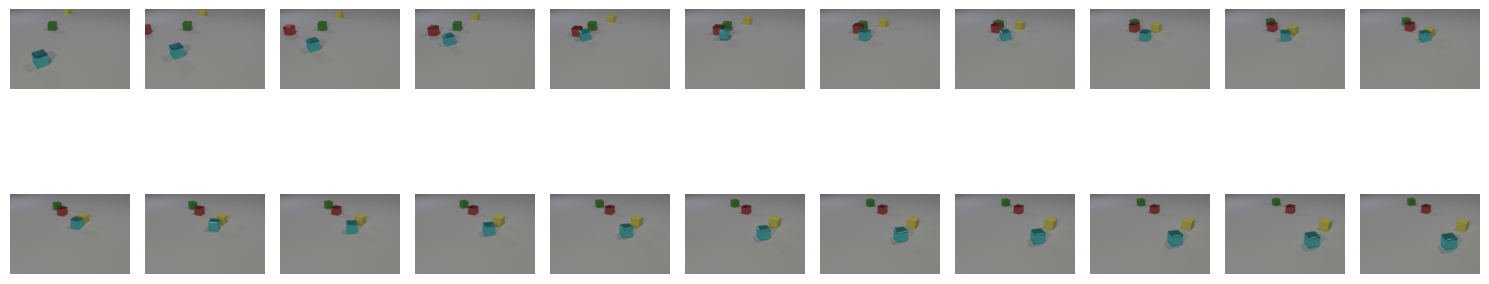

In [3]:
import math
import matplotlib.pyplot as plt

def vis_video(image_list, num_cols=11):
    # Define the number of columns for the subplot grid
    num_rows = math.ceil(len(image_list) / num_cols)
    
    # Create a figure and axis object with the appropriate number of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))  # Adjust figsize as needed
    
    # Iterate over the images and display each one in a subplot
    for i, image in enumerate(image_list):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(image)
        axes[row, col].axis('off')  # Turn off axis labels

    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()

vis_video(train_data[0])

In [4]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name='custom'):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

In [5]:
batch_size = 1

In [6]:
X_train = np.array([v[:11] for v in train_data])
X_train = np.reshape(X_train, (-1, 11, 3, 160, 240))
X_test = np.array([v[:11] for v in test_data])
X_test = np.reshape(X_test, (-1, 11, 3, 160, 240))
X_train.shape

(1000, 11, 3, 160, 240)

In [7]:
Y_train = np.array([v[11:] for v in train_data])
Y_train = np.reshape(X_train, (-1, 11, 3, 160, 240))
Y_test = np.array([v[:11] for v in test_data])
Y_test = np.reshape(X_test, (-1, 11, 3, 160, 240))
Y_train.shape

(1000, 11, 3, 160, 240)

In [8]:
train_set = CustomDataset(X=X_train, Y=Y_train)
test_set = CustomDataset(X=X_test, Y=Y_test)

dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

In [9]:
dataloader_train

In [10]:
pre_seq_length = 11
aft_seq_length = 11

In [11]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 3,
    'lr': 0.001,
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [11, 3, 160, 240],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are:
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters
    # 'config_file': 'configs/custom/example_model.py',

    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

In [12]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update default parameters
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_test, dataloader_test), strategy='auto')


/ext3/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<



  | Name      | Type        | Params
------------------------------------------
0 | model     | SimVP_Model | 20.4 M
1 | criterion | MSELoss     | 0     
------------------------------------------
20.4 M    Trainable params
0         Non-trainable params
20.4 M    Total params
81.475    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.8.r11.8/compiler.31833905_0
GPU 0: Quadro RTX 8000
GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
PyTorch: 2.2.2+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.2 (Git Hash 2dc95a2ad0841e29db8b22fbccaf3e5da7992b01)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_8

Epoch 0, global step 1000: 'val_loss' reached 0.00009 (best 0.00009), saving model to '/scratch/yg2709/Deep-Learning/Final Project Playground/work_dirs/custom_exp/checkpoints/best-epoch=00-val_loss=0.000.ckpt' as top 1


Epoch 1: 100%|██████████| 1000/1000 [01:40<00:00,  9.97it/s, v_num=1, train_loss_step=4.1e-5, train_loss_epoch=0.00124] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1000/1000 [00:42<00:00, 23.73it/s]Epoch 1: Lr: 0.0004619 | Train Loss: 0.0012406 | Vali Loss: 0.0000399

Epoch 1: 100%|██████████| 1000/1000 [02:23<00:00,  6.99it/s, v_num=1, train_loss_step=4.1e-5, train_loss_epoch=5.04e-5]

Epoch 1, global step 2000: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/scratch/yg2709/Deep-Learning/Final Project Playground/work_dirs/custom_exp/checkpoints/best-epoch=01-val_loss=0.000.ckpt' as top 1


Epoch 2: 100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s, v_num=1, train_loss_step=9.57e-6, train_loss_epoch=5.04e-5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1000/1000 [00:44<00:00, 22.64it/s]Epoch 2: Lr: 0.0000000 | Train Loss: 0.0000504 | Vali Loss: 0.0000097

Epoch 2: 100%|██████████| 1000/1000 [02:25<00:00,  6.87it/s, v_num=1, train_loss_step=9.57e-6, train_loss_epoch=1.39e-5]

Epoch 2, global step 3000: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/scratch/yg2709/Deep-Learning/Final Project Playground/work_dirs/custom_exp/checkpoints/best-epoch=02-val_loss=0.000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1000/1000 [02:26<00:00,  6.83it/s, v_num=1, train_loss_step=9.57e-6, train_loss_epoch=1.39e-5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Testing DataLoader 0: 100%|██████████| 1000/1000 [00:45<00:00, 21.85it/s]